# ✅ TensorFlow Test & Evaluation Notebook
Use this notebook inside your **Python (tf39)** environment.

In [ ]:

import os
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam

# Paths
dataset_path = "C:/Users/anar1/Desktop/DIGITAL PROJECT/training_dataset"

# Image parameters
img_height, img_width = 224, 224
batch_size = 32

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
)

# Custom generator to separate color and status labels
def extract_labels(path):
    folder = os.path.basename(os.path.dirname(path))
    color, status = folder.split('_')
    return color, status

class DualLabelGenerator(tf.keras.utils.Sequence):
    #This is where we set up the machine.

#We give it:

#A list of image file paths

#A list of answers for each image (like "blue", "ok")

#How many pictures per group (batch_size)

#How big the images should be (224x224 pixels)

#And whether to mix the pictures randomly or not (shuffle)
#These get saved so we can use them later when we give pictures to the student.
    def __init__(self, file_paths, labels, batch_size, img_size, shuffle=True):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()
#count how many batches we have
#If you have 100 pictures and you want to give 10 at a time , you have 10 batches.
    def __len__(self):
        return len(self.file_paths) // self.batch_size
#After the student sees all the pictures once (this is called an epoch), 
#we shuffle the pictures so they come in a new order next time. This helps the student learn better and not memorize
    def on_epoch_end(self):
        if self.shuffle:
            zipped = list(zip(self.file_paths, self.labels))
            random.shuffle(zipped)
            self.file_paths, self.labels = zip(*zipped)
#This is the most important part!

#Let’s say your machine is asked: “Hey, give me batch number 3.”

#Here’s what happens:
#Get the file names and labels for this batch:
    def __getitem__(self, idx):#Get the file names and labels for this batch
        batch_paths = self.file_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        color_labels = []
        status_labels = []
#Go through each picture in the batch:
        for path, (color, status) in zip(batch_paths, batch_labels):#Load the images and answers
            img = tf.keras.preprocessing.image.load_img(path, target_size=self.img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0 #Convert it to numbers (the computer understands pictures as arrays of numbers between 0 and 1
            images.append(img_array)
            color_labels.append(0 if color == 'blue' else 1)#Convert the answers to numbers:
            status_labels.append(0 if status == 'nok' else 1)
            #This picture = [array of pixels],
#Color label = 0 (blue),
#Status label = 1 (ok)
#We give back
#A group of images (like a stack of 32 resized pictures)
#A set of answers:
#For color (32 numbers: 0 or 1)
#For status (32 numbers: 0 or 1)
        return tf.convert_to_tensor(images), {'color': tf.convert_to_tensor(color_labels),
                                              'status': tf.convert_to_tensor(status_labels)}
#The model (our student) uses this batch to
# Gather dataset
file_paths = []
labels = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_path = os.path.join(root, file)
            color, status = extract_labels(full_path)
            file_paths.append(full_path)
            labels.append((color, status))

# Split into train and val
from sklearn.model_selection import train_test_split
train_paths, val_paths, train_labels, val_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

train_gen = DualLabelGenerator(train_paths, train_labels, batch_size, (img_height, img_width))
val_gen = DualLabelGenerator(val_paths, val_labels, batch_size, (img_height, img_width), shuffle=False)

# Model
inputs = Input(shape=(img_height, img_width, 3))

x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

# Two output heads
color_output = layers.Dense(1, activation='sigmoid', name='color')(x)
status_output = layers.Dense(1, activation='sigmoid', name='status')(x)

model = models.Model(inputs=inputs, outputs=[color_output, status_output])
model.compile(optimizer=Adam(),
              loss={'color': 'binary_crossentropy', 'status': 'binary_crossentropy'},
              metrics={'color': 'accuracy', 'status': 'accuracy'})

# Train
history = model.fit(train_gen, validation_data=val_gen, epochs=10)

#model.fit(train_gen, validation_data=val_gen, epochs=10)

# Save model
model.save("dual_output_piece_classifier.h5")
print("✅ Model saved as 'dual_output_piece_classifier.h5'")


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 84s 6s/step - color_accuracy: 0.6234 - color_loss: 2.1074 - loss: 5.0652 - status_accuracy: 0.6723 - status_loss: 2.9578 - val_color_accuracy: 1.0000 - val_color_loss: 0.0816 - val_loss: 0.5870 - val_status_accuracy: 0.7812 - val_status_loss: 0.5053
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 70s 5s/step - color_accuracy: 0.9952 - color_loss: 0.0398 - loss: 0.4348 - status_accuracy: 0.8614 - status_loss: 0.3950 - val_color_accuracy: 0.9792 - val_color_loss: 0.0643 - val_loss: 0.3792 - val_status_accuracy: 0.8542 - val_status_loss: 0.3149
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - color_accuracy: 1.0000 - color_loss: 0.0088 - loss: 0.1330 - status_accuracy: 0.9537 - status_loss: 0.1242 - val_color_accuracy: 1.0000 - val_color_loss: 0.0072 - val_loss: 0.1716 - val_status_accuracy: 0.9688 - val_status_loss: 0.1644
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 62s 5s/step - color_accuracy: 1.0000 - color_loss: 1.6744e-04 - loss: 0.0611 - status_accuracy: 0.

✅ Model saved as 'dual_output_piece_classifier.h5'


In [3]:
# ✅ Check TensorFlow version
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [4]:
# ✅ Load your trained model
model = tf.keras.models.load_model("dual_output_piece_classifier.h5")
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 111, 111,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 54, 54,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 52, 52,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 346112)    │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 44,302,464 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ color (Dense)       │ (None, 1)         │        129 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ status (Dense)      │ (None, 1)         │        129 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 44,395,972 (169.36 MB)

 Trainable params: 44,395,970 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [6]:
# ✅ Evaluate on a small batch (example, adapt paths if needed)
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

img = load_img(
    r"C:\Users\anar1\Desktop\DIGITAL PROJECT\training_dataset\blue_ok\cam320x240-BOHOMIPO2-1665095395480.jpeg",
    target_size=(224, 224)
)

#img = load_img("cam320x240-BOHOMIPO2-1665095395480.jpeg", target_size=(224, 224))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
color_pred = 'blue' if pred[0][0] < 0.5 else 'white'
status_pred = 'nok' if pred[1][0] < 0.5 else 'ok'

print("Predicted Color:", color_pred)
print("Predicted Status:", status_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
Predicted Color: blue
Predicted Status: ok


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


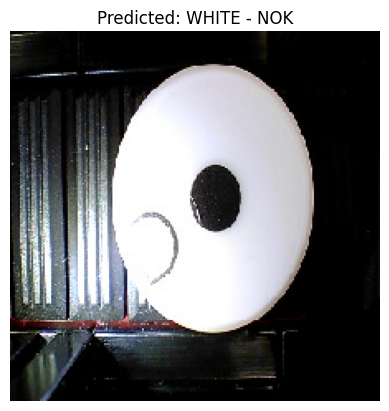

In [11]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load image
img_path = r"C:\Users\anar1\Desktop\DIGITAL PROJECT\training_dataset\white_nok\cam320x240-BOHOMIPO1-1665095395509.jpeg"  # 🔁 Replace with full path
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)
color_pred = 'blue' if pred[0][0] < 0.5 else 'white'
status_pred = 'nok' if pred[1][0] < 0.5 else 'ok'

# Show image with prediction
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {color_pred.upper()} - {status_pred.upper()}")
plt.show()


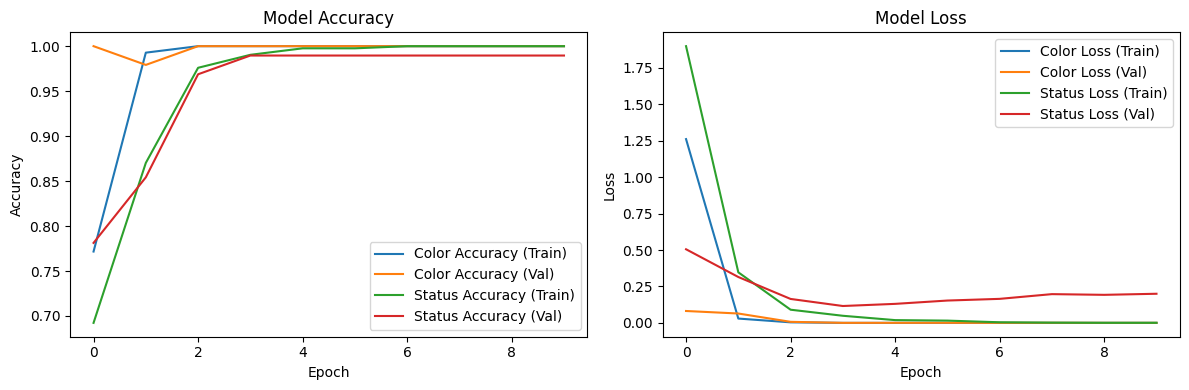

In [12]:
import matplotlib.pyplot as plt

# Accuracy plots
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['color_accuracy'], label='Color Accuracy (Train)')
plt.plot(history.history['val_color_accuracy'], label='Color Accuracy (Val)')
plt.plot(history.history['status_accuracy'], label='Status Accuracy (Train)')
plt.plot(history.history['val_status_accuracy'], label='Status Accuracy (Val)')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss plots
plt.subplot(1, 2, 2)
plt.plot(history.history['color_loss'], label='Color Loss (Train)')
plt.plot(history.history['val_color_loss'], label='Color Loss (Val)')
plt.plot(history.history['status_loss'], label='Status Loss (Train)')
plt.plot(history.history['val_status_loss'], label='Status Loss (Val)')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()
